# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [464]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [465]:
r = 15.0
N = 2000
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [466]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [467]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [468]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Nitrogen - Introducing Molecular Liquids and the Coulomb Potential

We want to look at more than just simple Lennard-Jones fluids. We can consider an uncharged homonuclear diatomic molecule, and nitrogen is a good such example.
Lets define the parameters, system and units.

In [469]:
T = 72.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

n2_epsilon = 44.0 * 8.314462618e-3 # kJ / mol
n2_sigma = 3.341 # Angstroms
n2_density = 0.01867 # 1 / Angstroms^3

n2_rho = np.diag([n2_density, n2_density])

Notice that we've defined a bond length here. We need this for computing the $\omega(k)$.

First we need to define the shape of our arrays. We're still working $N$ grid points but we're now dealing with 2 atoms (or sites in the terminology of RISM).

It's useful to define a variable for our system size.

In [470]:
ns = 2 # Number of sites

n2_wk = np.zeros((N, ns, ns)) # 3D array of number of points X number of sites X number of sites

Now we need to define what the intramolecular correlation function looks like $$\omega_{ij}(k) = \delta_{ij} + (1 - \delta_{ij})\frac{\sin(kd_{ij})}{kd_{ij}}$$
where $\delta_{ij}$ is the Kronecker delta, and $d_{ij}$ is the distance between site $i$ and $j$.


For nitrogen, we can explicitly define these for each $ij$ pair. If we number both nitrogens as $\textrm{N}_1$ and $\textrm{N}_2$ and we state the bond length between them to be $1.1\, Å$ then we can write 

$$\omega_{\textrm{N}_1 \textrm{N}_1} = \omega_{\textrm{N}_2 \textrm{N}_2} = 1$$

$$\omega_{\textrm{N}_1 \textrm{N}_2} = \omega_{\textrm{N}_2 \textrm{N}_1} = \frac{\sin(1.1k)}{1.1k}$$

In [471]:
n2_bond_length = 1.1

# [:, 0, 0] indicates a slice over the first axis (which we defined as the number of points above, and indexing the last 2 axes explicitly with 0 and 0 (or 1 and 1) etc.
n2_wk[:, 0, 0] = n2_wk[:, 1, 1] = np.ones(N)
n2_wk[:, 0, 1] = n2_wk[:, 1, 0] = np.sin(k_grid * n2_bond_length) / k_grid / n2_bond_length

We can compute the potential in a similar fashion

In [472]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

n2_ur = np.zeros((N, ns, ns))

n2_ur[:, 0, 0] = n2_ur[:, 0, 1] = n2_ur[:, 1, 0] = n2_ur[:, 1, 1] = LJ(n2_epsilon, n2_sigma, r_grid)

We can do it like this because the two interaction sites are essentially equivalent, they have the exact same LJ parameters and charge, even if they are in different positions in space. We've accounted for the spatial difference with $\omega(k)$.

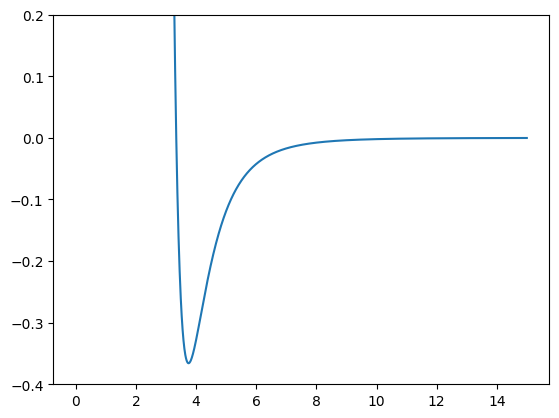

In [473]:
plt.plot(r_grid, n2_ur[:, 0, 0])
plt.ylim([-0.4, 0.2])
plt.show()

We have our inputs (the potential energy and the intramolecular correlation function), so lets solve the RISM equation.

We're going to actually wrap a solver in a function for easier use in the future.

In [474]:
def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur, wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = PY(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

Before we start the solver, there's something else we need to consider - the fbt and ifbt functions.

We wrote them for 1D arrays in mind, but we're working with 3D arrays now. If you were try to use the above function without modifying the fbt and ifbt functions, you'd see that it wouldn't work because the r and k grids are not 3D, they're 1D, but our fr and fk grids are 3D now.

We need to refactor them for 3D arrays. Fortunately this is an easy fix, we just need to introduce a new axis to the r and k grid. These are just empty axes that Numpy uses to properly broadcast a 1D array over 3D arrays.

In [475]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

def PY(beta, ur, tr):
    return np.exp(-beta * ur) * (1.0 + tr) - 1.0 - tr

def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

def RISM(cr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr


We also have a slightly more complicated problem on our hands now. Using an initial guess of 0 might not cut it, so we'll try using the Mayer-f function as an initial guess

$$ f(r) = e^{-\beta u(r)} - 1 $$

Iteration: 0 Diff: 2.68e+00


Iteration: 100 Diff: 6.77e-02
Iteration: 200 Diff: 3.42e-02
Iteration: 300 Diff: 2.17e-02
Iteration: 400 Diff: 1.30e-02
Iteration: 500 Diff: 7.40e-03
Iteration: 600 Diff: 4.12e-03
Iteration: 700 Diff: 2.25e-03
Iteration: 800 Diff: 1.22e-03
Iteration: 900 Diff: 6.56e-04
Iteration: 1000 Diff: 3.53e-04
Iteration: 1100 Diff: 1.89e-04
Iteration: 1200 Diff: 1.01e-04
Iteration: 1300 Diff: 5.43e-05
Iteration: 1400 Diff: 2.91e-05
Iteration: 1500 Diff: 1.56e-05
Iteration: 1600 Diff: 8.34e-06
Iteration: 1700 Diff: 4.47e-06
Iteration: 1800 Diff: 2.39e-06
Iteration: 1900 Diff: 1.28e-06
Final Iteration: 1940 Diff: 9.97e-07


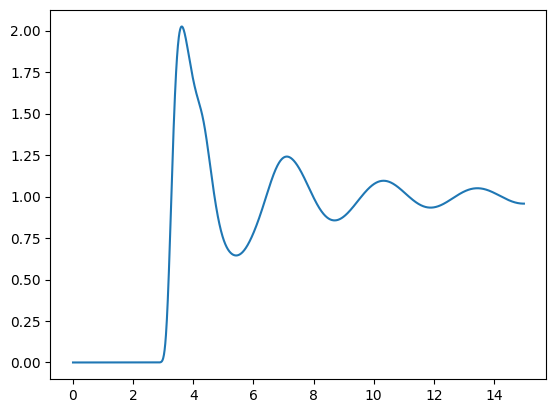

In [476]:
tolerance = 1e-6
max_step = 10000
alpha = 0.1
initial_tr = np.zeros((N, ns, ns))
tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, n2_ur, n2_wk, n2_rho)
cr = PY(beta, n2_ur, tr)
hr = tr + cr
gr = hr + 1.0

gn = gr[:, 0, 0]
plt.plot(r_grid, gr[:, 0, 0])
plt.show()

1000 iterations doesn't seem to cut it on my machine. We might need to introduce a new scheme to help with convergence.

We're going to introduce charging, which is where we slowly switch on the potential and run the solver at each stage.

In [477]:
tolerance = 1e-7
max_step = 10000
alpha = 0.5
initial_tr = np.zeros((N, ns, ns))
lambdas = 3

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * n2_ur, n2_wk, n2_rho)
    initial_tr = tr

cr = PY(beta, n2_ur, tr)

0.3333333333333333
Iteration: 0 Diff: 7.25e+00
Iteration: 100 Diff: 2.88e-03
Iteration: 200 Diff: 2.78e-05
Iteration: 300 Diff: 2.70e-07
Final Iteration: 322 Diff: 9.73e-08
0.6666666666666666
Iteration: 0 Diff: 7.87e+00
Iteration: 100 Diff: 2.55e-03
Iteration: 200 Diff: 7.76e-05
Iteration: 300 Diff: 2.37e-06
Final Iteration: 391 Diff: 9.90e-08
1.0
Iteration: 0 Diff: 1.73e+01
Iteration: 100 Diff: 1.48e-03
Iteration: 200 Diff: 6.23e-05
Iteration: 300 Diff: 2.63e-06
Iteration: 400 Diff: 1.11e-07
Final Iteration: 404 Diff: 9.81e-08


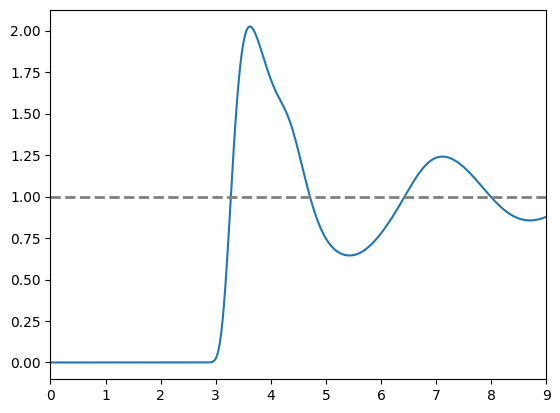

In [478]:
hr = tr + cr

gr = hr + 1.0

plt.plot(r_grid, gr[:, 0, 0])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.show()

In order to do that, we need to be able to properly model the long-range electrostatics via the Coulomb potential.
A problem that arises is properly dealing with the long-range part when performing a Fourier transform - the potential will diverge!

A simple solution is to break the potential energy into two parts - a short and long range component.
Perform the fast Fourier transform for the short range component but choose the long-range component such that we can analytically transform it.

We will choose such a form in a moment, first we should define the model we want to solve.

The model is essentially the same as before but we introduce a chage of $0.2\, e$ and $-0.2\, e$ on each nitrogen atom.

In [479]:
T = 72.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

n2_epsilon = 44.0 * 8.314462618e-3 # kJ / mol
n2_sigma = 3.341 # Angstroms
n2_density = 0.01867 # 1 / Angstroms^3

n2_charge = 0.2 #ec

n2_rho = np.diag([n2_density, n2_density])

In [480]:
ec = 1.602176565e-19 # A*s
eps_0 = 8.854187817620e-12 # A^2*s^4/kg/m^3
Na = 6.02214129e23 # 1 / mol
kc = 1.0 / 4.0 / np.pi/ eps_0 # J*m/A^2/s^2
kc_a = kc * 1e10 # J*angstrom/A^2/s^2
kc_akj = kc_a * 1e-3 # kJ*angstrom/A^2/s^2
kc_akjmol = kc_akj * Na # kJ*angstrom/A^2/s^2/mol
lb = ec * ec * kc_akjmol # kJ*angstrom/mol

def Coulomb(q, r):
    return lb * q / r

from scipy.special import erf

def Ng_real(q, r):
    return lb * q * erf(r) / r

def Ng_fourier(q, k):
    return 4.0 * np.pi * lb * q * np.exp(-np.power(k, 2.0) / 4.0) / np.power(k, 2.0)


In [481]:
n2_lj = np.zeros((N, ns, ns))
n2_cou = np.zeros((N, ns, ns))
n2_ng_real = np.zeros((N, ns, ns))
n2_ng_fourier = np.zeros((N, ns, ns))

n2_lj[:, 0, 0] = n2_lj[:, 0, 1] = n2_lj[:, 1, 0] = n2_lj[:, 1, 1] = LJ(n2_epsilon, n2_sigma, r_grid)

n2_cou[:, 0, 0] = n2_cou[:, 1, 1] = Coulomb(n2_charge * n2_charge, r_grid)
n2_cou[:, 0, 1] = n2_cou[:, 1, 0] = Coulomb(-n2_charge * n2_charge, r_grid)

n2_ng_real[:, 0, 0] = n2_ng_real[:, 1, 1] = Ng_real(n2_charge * n2_charge, r_grid)
n2_ng_real[:, 0, 1] = n2_ng_real[:, 1, 0] = Ng_real(-n2_charge * n2_charge, r_grid)

n2_ng_fourier[:, 0, 0] = n2_ng_fourier[:, 1, 1] = Ng_fourier(n2_charge * n2_charge, k_grid)
n2_ng_fourier[:, 0, 1] = n2_ng_fourier[:, 1, 0] = Ng_fourier(-n2_charge * n2_charge, k_grid)

In [482]:
def RISM(cr, vk_lr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = PY(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

In [484]:
tolerance = 1e-7
max_step = 10000
alpha = 0.5
initial_tr = np.zeros((N, ns, ns))
lambdas = 3

n2_ur = n2_lj + n2_cou
n2_ur_sr = n2_ur - n2_ng_real

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * n2_ur_sr, lam * n2_ng_fourier, n2_wk, n2_rho)
    initial_tr = tr


cr = PY(beta, n2_ur_sr, tr) - beta * n2_ng_real
tr += beta * n2_ng_real

0.3333333333333333
Iteration: 0 Diff: 7.88e+00
Iteration: 100 Diff: 1.13e-01
Iteration: 200 Diff: 2.13e-02
Iteration: 300 Diff: 3.24e-03
Iteration: 400 Diff: 4.75e-04
Iteration: 500 Diff: 6.92e-05
Iteration: 600 Diff: 1.01e-05
Iteration: 700 Diff: 1.47e-06
Iteration: 800 Diff: 2.13e-07
Final Iteration: 840 Diff: 9.86e-08
0.6666666666666666
Iteration: 0 Diff: 8.45e+00
Iteration: 100 Diff: 1.07e-01
Iteration: 200 Diff: 2.73e-02
Iteration: 300 Diff: 5.86e-03
Iteration: 400 Diff: 1.20e-03
Iteration: 500 Diff: 2.44e-04
Iteration: 600 Diff: 4.96e-05
Iteration: 700 Diff: 1.01e-05
Iteration: 800 Diff: 2.04e-06
Iteration: 900 Diff: 4.13e-07
Final Iteration: 989 Diff: 9.99e-08
1.0
Iteration: 0 Diff: 1.75e+01
Iteration: 100 Diff: 9.86e-02
Iteration: 200 Diff: 2.88e-02
Iteration: 300 Diff: 7.29e-03
Iteration: 400 Diff: 1.77e-03
Iteration: 500 Diff: 4.27e-04
Iteration: 600 Diff: 1.03e-04
Iteration: 700 Diff: 2.46e-05
Iteration: 800 Diff: 5.91e-06
Iteration: 900 Diff: 1.42e-06
Iteration: 1000 Diff: 

True
[]


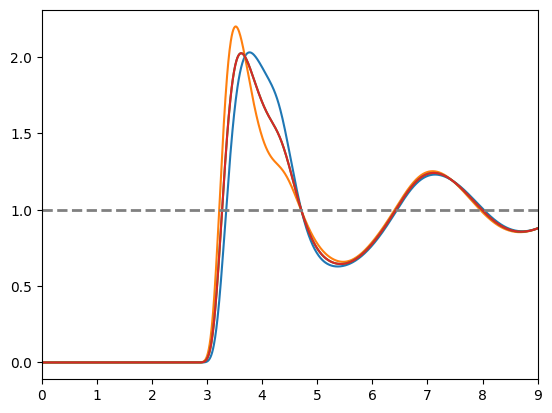

In [524]:
hr = tr + cr

gr = hr + 1.0

gpp = gr[:, 0, 0]
gpn = gr[:, 0, 1]

print(np.all(np.isclose(2 * gn, gpp + gpn, atol=1e-4, rtol=1e-8)))

idx = np.where(np.isclose(2 * gn, gpp + gpn, atol=1e-4, rtol=1e-8) == False)

print(abs((2 * gn) - (gpp + gpn))[idx])

plt.plot(r_grid, gpp)
plt.plot(r_grid, gpn)
plt.plot(r_grid, gn)
plt.plot(r_grid, (gpp + gpn) / 2.0)
plt.scatter(r_grid[idx], gn[idx], marker=".")
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.show()